This notebook is for creating the base ML model.

In [1]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('../../data_evaluation/taxi_trip_data/all_tlc_data_cleaned.parquet')
df.rename({'passenger_count':'busyness'},axis=1, inplace=True)
print(df.columns)

Index(['datetime', 'location', 'busyness'], dtype='object')


In [3]:
df.shape

(7319643, 3)

In [4]:
df.head()

,datetime,location,busyness
0,2021-01-01,3,132
1,2021-01-01,4,234
2,2021-01-01,5,19
3,2021-01-01,6,37
4,2021-01-01,7,493


In [5]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="location",
    timestamp_column="datetime"
)
print(data.head())

                    busyness
item_id timestamp           
3       2021-01-01       132
4       2021-01-01       234
5       2021-01-01        19
6       2021-01-01        37
7       2021-01-01       493


In [6]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [7]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    eval_metric="MASE",
    prediction_length=prediction_length,
    path="base_model_no_bucketing_model_files"
)
print('we made the predictor')

we made the predictor


In [8]:
predictions = predictor.fit(train_data,
                                presets="medium_quality"
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'base_model_no_bucketing_model_files'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       8.46 GB / 15.90 GB (53.2%)
Disk Space Avail:   2136.50 GB / 2794.50 GB (76.5%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'busyness',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'h'.
Provided train_data has 6826363 rows (NaN fraction=

In [9]:
print(predictor.leaderboard())

              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -1.135472     675.172620          90.602790          7
1     SeasonalNaive  -1.339581       1.059091           4.595214          2
2     DirectTabular  -1.823986      45.355734         179.019427          4
3  RecursiveTabular  -1.856304     573.571192         332.643793          3
4             Theta  -2.269781      51.387805           5.058170          6
5             Naive  -2.354159       3.798799           4.666282          1
6               ETS  -9.005625     204.945785           4.802066          5


In [10]:
predictions = predictor.predict(train_data)
print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


                                   mean         0.1         0.2         0.3  \
item_id timestamp                                                             
3       2024-01-01 23:00:00  150.406304  117.598475  128.811250  136.900164   
        2024-01-02 00:00:00   90.177626   52.017917   65.111703   74.547917   
        2024-01-02 01:00:00  114.632728   72.357663   86.861383   97.305563   
        2024-01-02 02:00:00  102.652654   57.051175   72.696661   83.999238   
        2024-01-02 03:00:00   65.333512   16.578357   33.302532   45.379559   
...                                 ...         ...         ...         ...   
110     2022-04-23 13:00:00    1.180407  -13.387425   -8.386960   -4.778570   
        2022-04-23 14:00:00    1.166716  -13.403675   -8.401150   -4.791321   
        2022-04-23 15:00:00    1.164488  -13.409980   -8.405470   -4.796331   
        2022-04-23 16:00:00    1.160578  -13.417217   -8.409801   -4.800188   
        2022-04-23 17:00:00    1.177084  -13.415267 

In [11]:
# plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=40)


data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.


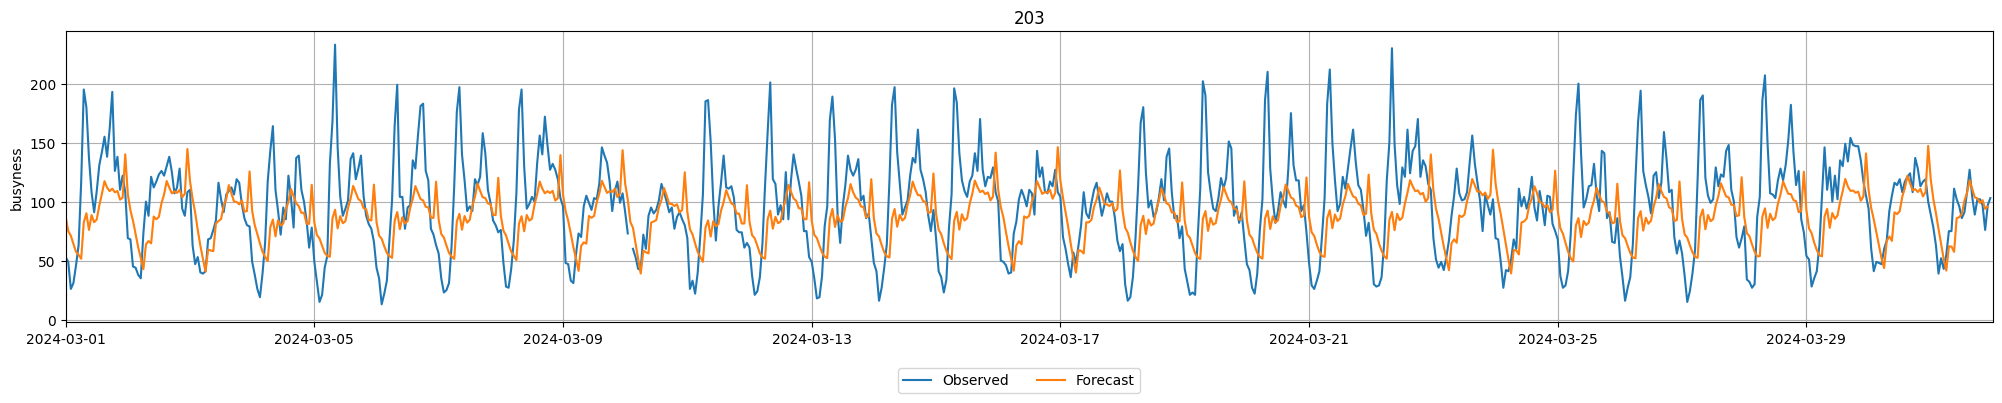

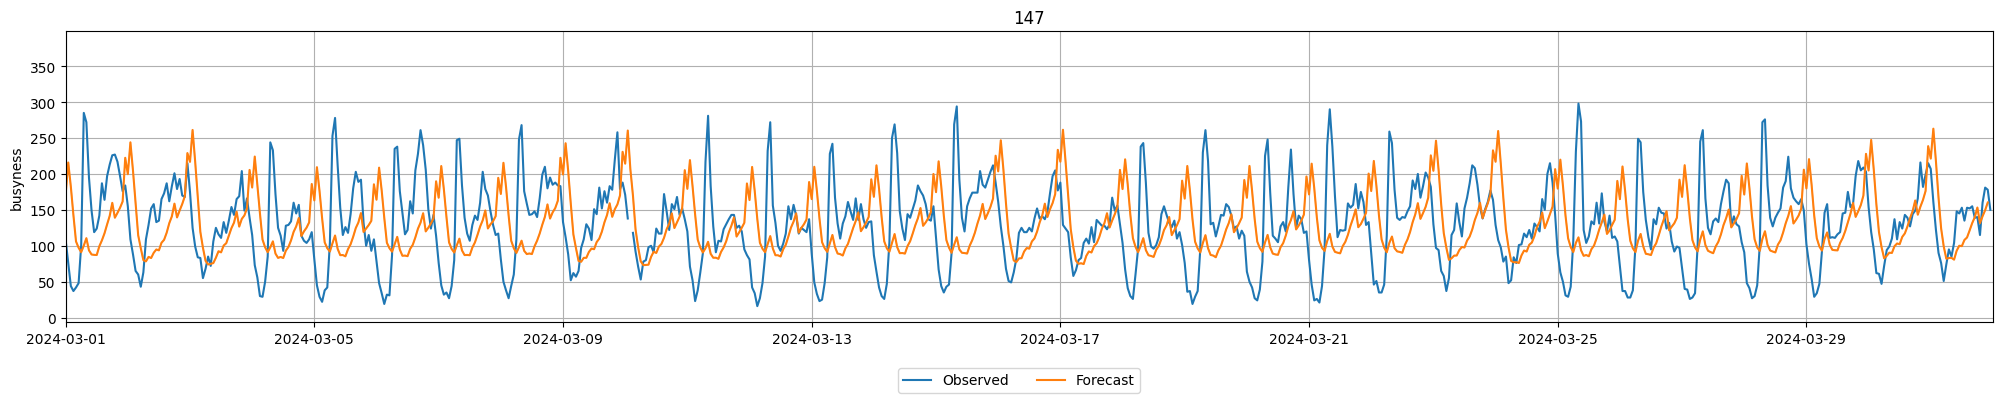

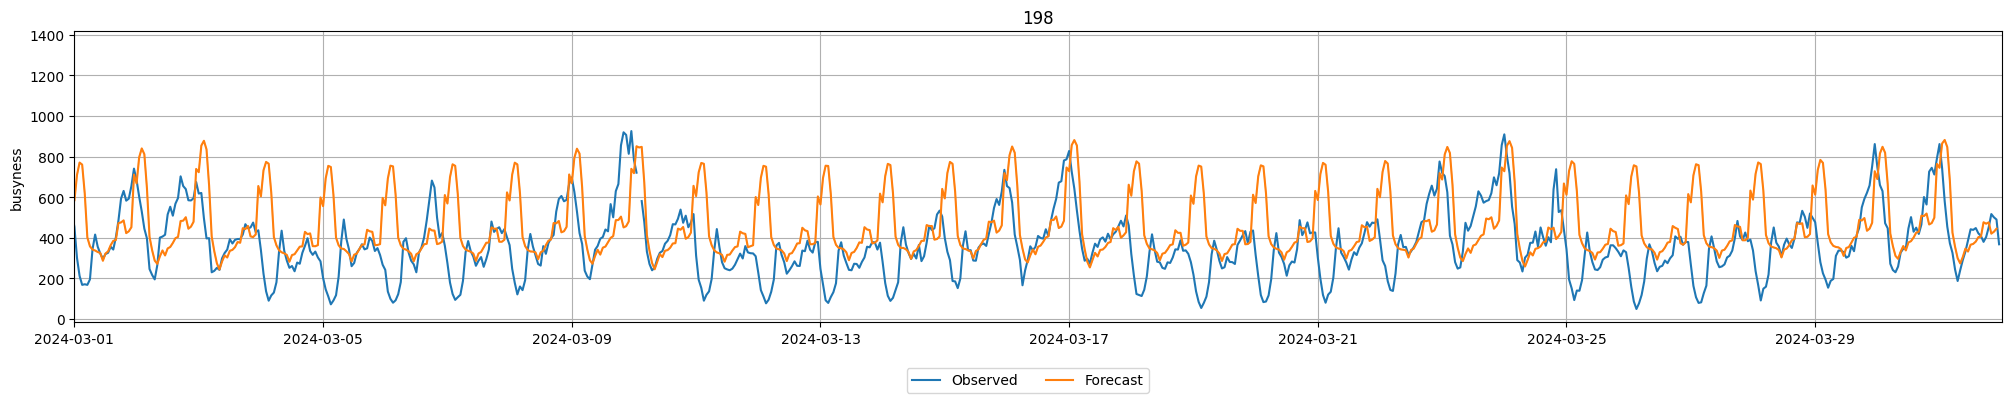

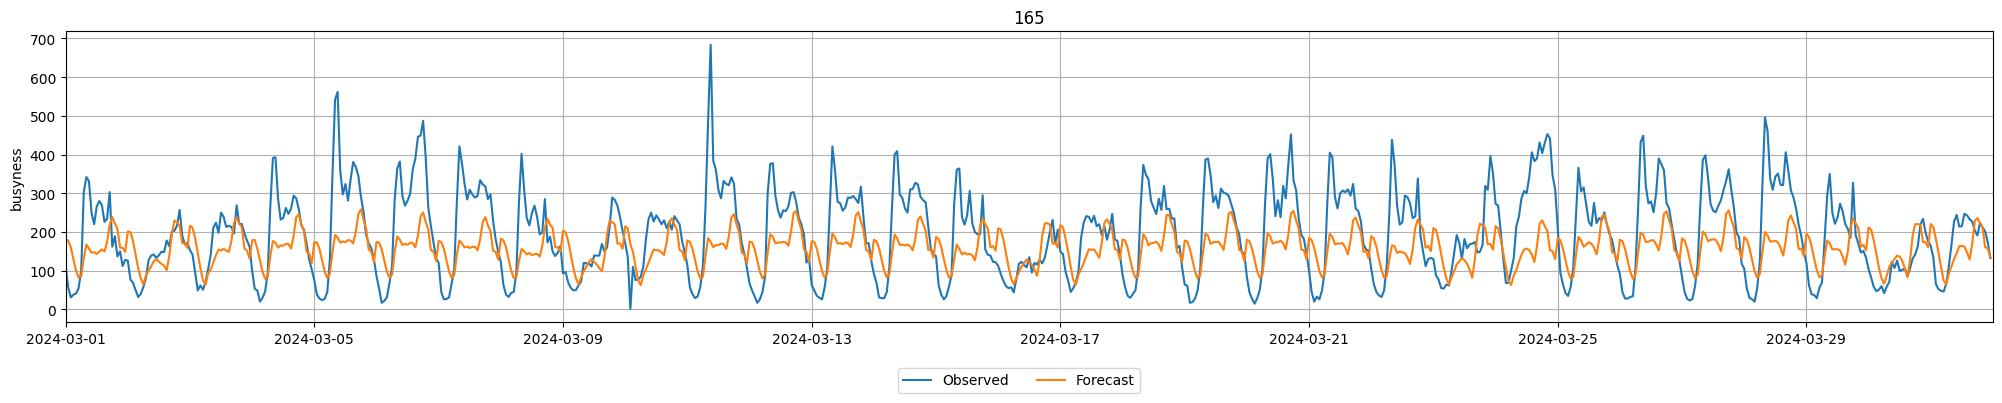

In [12]:
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
item_ids = [203, 147, 198, 165]
for id in item_ids:
    plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  item_ids=[id])
    ax = plot.gca()
    ax.set_xlim([xmin, xmax])
plt.show()

In [13]:
# predictor.evaluate(test_data)